# Drilling performance

## Introduction

Measurement of performance is vital to business success and most performance studies are related to key performance indicators (KPIs). A Key performance indicator is a metric, measuring how well the organization is performing on operational, tactical or strategic activities that is critical for the current and future success of the organization.
In the Oil and Gas industry, KPIs can be used for monitoring and measuring operational quality performance. In Drilling, a process whereby a hole is bored using a drill bit to create a well for oil and natural gas production, one example of KPI would be the Slip to Slip connection time. This KPI can offer significant improvements in identifying sources of Non-Productive Time.
The Slips is a device used to grip and hold the upper part of a drill pipe to the drill floor, which is the area where the pipe begins its trip into the earth. The Slips is used when making a connection: the pipes are jointed in order to advance further into the hole. Therefore, each pipe is picked up by a hook, temporarily gripped by the slips and then jointed to another pipe. After the joint, the slips is removed and the entire pipe is carefully lowered into the hole, resuming the
drilling. A skilled rig crew can physically accomplish all of those steps in a minute or two.


## The challenge

In this challenge, you should do an Exploratory Data Analysis (EDA) in order to extract useful information for the development of the KPI mentioned in the Introduction (Slip to Slip connection time).
We expect you to:
Describe the data;
Preprocess the data;
Define which strategy you used for missing values, if there are any;
Define which strategy you used for duplicated values, if there are any;
Usually sensor data has embedded some amount of noise. Analysis of such raw data may often fail to give accurate information. Define which strategy you used for dealing with noise.
Machine learning methods are usually based on the assumption that the data generation mechanism does not change over time. However, some series in the dataset don't present this characteristic, having its statistical properties changing over time. Define which strategy you used to deal with this problem.
Identify the most important variables for detecting when the slips is on or off ;
Identify relations between variables;
Build additional features that can help the detection of when the slips is on or off ;
Outline the conclusions you could reached with your analysis;

## Data

The data that represents a multivariate time series collected by sensors during a drilling operation and it's discretized by 1 second. In this operation, the pipe connections happen in the same manner as explained in the Introduction section.
In the data/ folder, you'll find:
challenge_dataset.csv - The file containing the data for the challenge, separated by comma.
variables_dictionary.txt - A text file explaining the meaning of each column in the dataset.

## Solution

After conducting research on the area and talking to Petrobras drilling professionals, I performed a data cleaning and data analysis in order to determine the slip-to-slip connection moments. The final result with the performance was presented through a dashboard created in Power BI.

# 0.0 IMPUTS

## 0.1 Imports

In [1]:
import numpy               as np
import pandas              as pd
import dataframe_image     as dfi
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from datetime              import datetime
from IPython.display       import Image
from IPython.core.display  import HTML

import warnings
warnings.filterwarnings( 'ignore' )

# Rescaling Features
from sklearn.preprocessing import MinMaxScaler
from scipy.stats           import pointbiserialr

## 0.2 Helpers Functions

In [2]:
def descriptive_statistics (num_df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_df.apply(np.mean)).T
    ct2 = pd.DataFrame(num_df.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_df.apply(np.std)).T
    d2 = pd.DataFrame(num_df.apply(min)).T
    d3 = pd.DataFrame(num_df.apply(max)).T
    d4 = pd.DataFrame(num_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    return m

## 0.3 Loading Data

In [3]:
df = pd.read_excel("data/challenge_dataset.xlsx", sheet_name='challenge_dataset')

In [4]:
df.head()

,WOBA.klbf,TQA.ft.lbf,RPMA.rpm,HKLA.klbf,DMEA.ft,DBTM.ft,BPOS.ft,MFOP.%,MFIA.galUS/min,MDOA.ppg,MDIA.ppg,ROPA.ft/h,DHWOB.klbf,DHTQ.ft.lbf,ECD.ppg,SPPA.psi,TIME.S
0,0,NaN,0.0,93.905,22207.8,4675.5,60.9,13.000,0,NaN,NaN,NaN,NaN,NaN,NaN,12.893,1533230780
1,0,NaN,0.0,94.492,22207.8,4675.5,60.9,14.000,0,NaN,NaN,NaN,NaN,NaN,NaN,13.034,1533230800
2,0,NaN,0.0,94.011,22207.8,4675.5,60.9,12.108,0,NaN,NaN,NaN,NaN,NaN,NaN,12.265,1533230820
3,0,NaN,0.0,93.910,22207.8,4675.5,60.9,13.000,0,NaN,NaN,NaN,NaN,NaN,NaN,14.602,1533230840
4,0,NaN,0.0,94.003,22207.8,4675.5,60.9,12.004,0,NaN,NaN,NaN,NaN,NaN,NaN,14.703,1533230860


# 1.0 DATA DESCRIPTION

In [5]:
df1 = df.copy()

## 1.1 Features Description

ALL UNITS ARE AFTER THE DOT (.) IN THE VARIABLES NAMES

- **WOBA.klbf**  = Weight-on-Bit (surfice, average)


- **TQA.ft.lbf**  = Rotary Torque (surface, average)


- **RPMA.rpm**  = Rotary Speed (surface, average)


- **HKLA.klbf**	 = Hookload (average)


- **DMEA.ft**  = Depth hole (measured)


- **DBTM.ft**  = Depth bit (measured)


- **BPOS.ft**  = Block position (in ft)


- **MFOP.%**  = Mud flow out (percentual )


- **MFIA.galUS/min**  = Mud flow in average (in galUS/min)


- **MDOA.ppg**  = Mud density out (average)


- **MDIA.ppg**  = Mud density in (average)


- **ROPA.ft/h**  = Rate of penetration (average)


- **DHWOB.klbf**  = Downhole weight on bit


- **DHTQ.ft.lbf**  = Downhole torque


- **ECD.ppg**  = Equivalent circulating density


- **SPPA.psi**  = Standpipe pressure (average)


- **TIME.S**  = Timestamp (in seconds)

## 1.2 Rename Columns

Although the nomenclature has different names and we use "_" instead of ".", I will keep the names given because I believe it is the nomenclature used by the company.

## 1.3 Data Dimentions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 14827
Number of cols: 17


In [7]:
aux1 = df1.iloc[1:2,:]
dfi.export(aux1, 'img/dataframe_df1.png')

## 1.4 Data Types

In [8]:
df1.dtypes

WOBA.klbf           int64
TQA.ft.lbf        float64
RPMA.rpm          float64
HKLA.klbf         float64
DMEA.ft           float64
DBTM.ft           float64
BPOS.ft           float64
MFOP.%            float64
MFIA.galUS/min      int64
MDOA.ppg          float64
MDIA.ppg          float64
ROPA.ft/h         float64
DHWOB.klbf        float64
DHTQ.ft.lbf       float64
ECD.ppg           float64
SPPA.psi          float64
TIME.S              int64
dtype: object

## 1.5 Check NA


In [9]:
df1 = df1.replace(-999.25,np.NaN)

In [10]:
df1.isna().sum()

WOBA.klbf             0
TQA.ft.lbf        14827
RPMA.rpm              0
HKLA.klbf             0
DMEA.ft               0
DBTM.ft               0
BPOS.ft               0
MFOP.%                0
MFIA.galUS/min        0
MDOA.ppg          14827
MDIA.ppg          14827
ROPA.ft/h         14827
DHWOB.klbf        14827
DHTQ.ft.lbf       14827
ECD.ppg           14827
SPPA.psi              0
TIME.S                0
dtype: int64

## 1.6 Fillout NA

### 1.6.1 Rate of penetration
As the Depth Hole does not vary over the entire dataframe and the maximum value reached by the Depth Bit is less than the Depth Hole value, we conclude that the Rate of Penetration (Depth Hole difference per hour) is equal to zero.

In [11]:
df1['ROPA.ft/h'] = 0

### 1.6.4 Excluding features

As there is no perforation and the **Mud flow in** is zero, we can conclude that there is no mud input, so we can disregard the features **Mud density in (MDIA.ppg)** and **Mud density out (MDOA.ppg)**.

For inclined and horizontal wells where part of the string is in direct contact with the wellbore wall, a correction for friction and inclination has to be made to correctly calculate the **Downhole weight on bit(DHWOB.klbf)**, as we don't have this measurements, the feature will also be disregarded.

**Equivalent Circulating Density (ECD.ppg)** is the effective density that combines current mud density and annular pressure drop. We also don't have this informations, so we will drop this feature.

In [12]:
cols_drop = ['MDOA.ppg', 'MDIA.ppg', 'DHWOB.klbf', 'ECD.ppg', 'TQA.ft.lbf', 'DHTQ.ft.lbf']
df1 = df1.drop(cols_drop, axis = 1)

## 1.7 Change Types

It is not necessary as all columns are numeric values.

## 1.8 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 1.8.1 Numerical Attributes

In [14]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,WOBA.klbf,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,RPMA.rpm,0.00,2.23,2.23,0.01,0.00,0.07,14.14,259.71
2,HKLA.klbf,40.28,351.80,311.51,132.15,97.89,64.85,1.62,1.11
3,DMEA.ft,9436.38,22207.80,12771.42,22206.94,22207.80,104.88,-121.77,14827.00
4,DBTM.ft,1986.68,19665.90,17679.22,10923.33,9017.00,4507.15,0.38,-1.06
5,BPOS.ft,6.60,86.90,80.30,34.20,25.20,18.94,0.43,-1.24
6,MFOP.%,0.00,39.00,39.00,10.19,17.00,9.90,-0.03,-1.95
7,MFIA.galUS/min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,ROPA.ft/h,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,SPPA.psi,0.00,22.82,22.82,5.12,0.00,6.91,0.66,-1.46


In [15]:
aux1 = descriptive_statistics(num_attributes)
dfi.export(aux1, 'img/dataframe_describe.png')

## 1.9 Outliers


### 1.9.1 Checking outliers

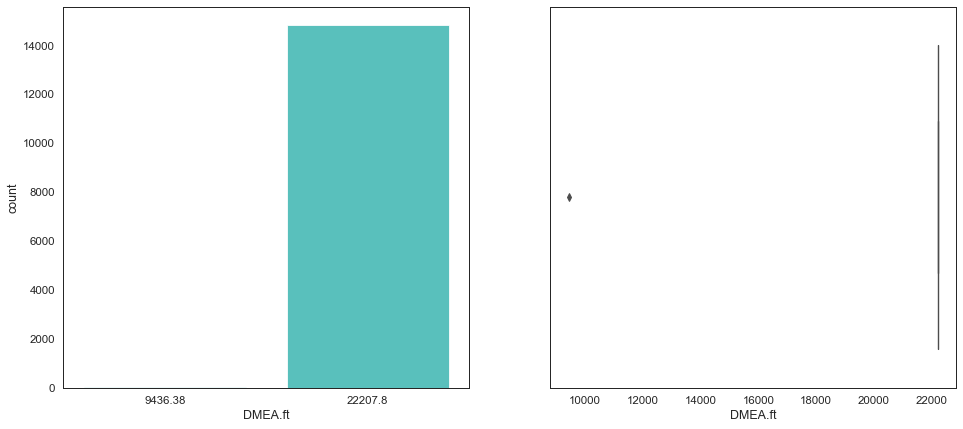

In [16]:
## DEPTH HOLE

sns.set(rc={'figure.figsize':(16,7)})
sns.set(style="white", context = "paper", font_scale=1.3)


# Countplot of Depth hole
plt.subplot(1,2,1)
sns_plot = sns.countplot(df1['DMEA.ft'], color = 'mediumturquoise');
#sns.color_palette("light:#5A9")

# Boxplot of Depth hole
plt.subplot(1,2,2)
sns.boxplot(df1['DMEA.ft']);
#sns.color_palette("light:#5A9")

fig = sns_plot.get_figure()
fig.savefig("img/DMEA_outlier.png")

In the graphs above we can notice the presence of 1 outlier, since the hole depth would not decrease 12,771.42 ft in 20 seconds and 20 seconds later return to the original value.

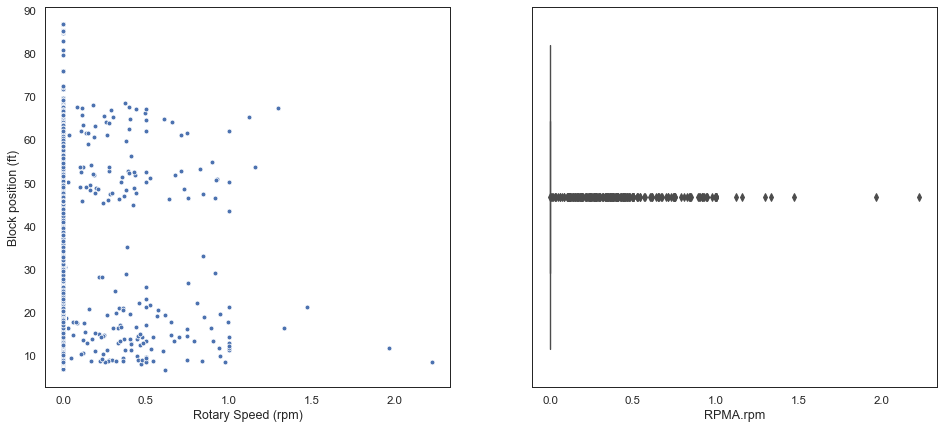

In [17]:
## ROTARY SPEED

sns.set(rc={'figure.figsize':(16,7)})
sns.set(style="white", context = "paper", font_scale=1.3)

# Scatterplot of Rotary Speed
plt.subplot(1,2,1)
sns.scatterplot(x="RPMA.rpm", y="BPOS.ft", data = df1, palette = 'winter')
plt.xlabel("Rotary Speed (rpm)")
plt.ylabel("Block position (ft)")


# Boxplot of Rotary Speed
plt.subplot(1,2,2)
sns_plot = sns.boxplot(df1['RPMA.rpm'])

fig = sns_plot.get_figure()
fig.savefig("img/RPMA_outlier.png")

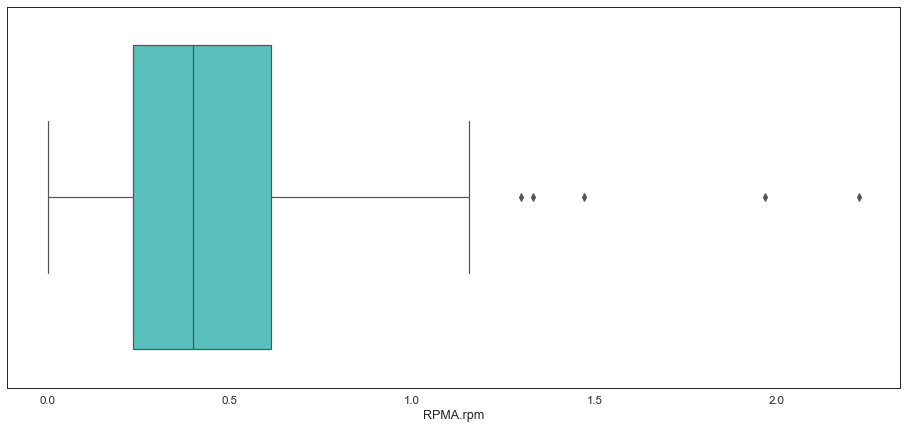

In [18]:
sns.set(rc={'figure.figsize':(16,7)})
sns.set(style="white", context = "paper", font_scale=1.3)

aux1 = df1[df1['RPMA.rpm']!=0]
sns_plot = sns.boxplot(aux1['RPMA.rpm'], color = 'mediumturquoise')

fig = sns_plot.get_figure()
fig.savefig("img/RPMA_outlier2.png")

Due to the range and distribution of the data, we will not consider any rotary speed value as an outlier.

### 1.9.2 Removing Outliers

In [19]:
df1["DMEA.ft"].value_counts()

22207.80    14826
9436.38         1
Name: DMEA.ft, dtype: int64

In [20]:
df1 = df1.loc[df1["DMEA.ft"] == 22207.80]

### 1.9.3 Exporting Data

In [21]:
df1.to_csv('data/clean_data.csv', index=False)

# 2.0 FEATURE ENGENEERING


In [22]:
df2 = df1.copy()

## 2.1 Making Hole (True or False)
The calculated value is simply TRUE if the actual Hole Depth is greater than the previous one, or FALSE if it is equal.

In [23]:
df2['Making_Hole'] = df2['DMEA.ft'].eq(df2['DMEA.ft'].shift( ))
df2['Making_Hole'] = np.invert(df2['Making_Hole'])

# The first data does not have a previous data as a reference, so we need to discard this measure replacing it with NaN.
df2.loc[0,'Making_Hole'] = 'nan'

In [24]:
df2['Making_Hole'].value_counts()

False    14825
nan          1
Name: Making_Hole, dtype: int64

## 2.2 Block Movement (in feet)
It represents the difference between two consecutive block height values, being positive if the block is moving up (actual height is greater then the previous) or negative if the opposite happens.

In [25]:
df2['Block_Movement'] = df2['BPOS.ft'].diff( )
df2.loc[0,'Block_Movement'] = 0

In [26]:
df2.columns

Index(['WOBA.klbf', 'RPMA.rpm', 'HKLA.klbf', 'DMEA.ft', 'DBTM.ft', 'BPOS.ft',
       'MFOP.%', 'MFIA.galUS/min', 'ROPA.ft/h', 'SPPA.psi', 'TIME.S',
       'Making_Hole', 'Block_Movement'],
      dtype='object')

## 2.3 Off Bottom Distance (in feet)
Represents the difference (in feet) between the depth of the dug hole and the depth of the bit.

In [27]:
aux1 = df2.iloc[:,[3,4]].diff(axis = 1)
df2['Off_Bottom_Dist'] = aux1['DBTM.ft']

## 2.4 Bit Motion (in feet)
It represents the difference between two consecutive Depth bit values, being positive if the bit is moving down (actual height is greater then the previous) or negative if the opposite happens.

In [28]:
df2['Bit_Motion'] = df2['DBTM.ft'].diff( )
df2.loc[0,'Bit_Motion'] = 0

## 2.5 Date Time
A combination of a date and a time. Attributes: month / day / year ,  hour : minute : second)

In [29]:
df2['DATETIME'] = df2['TIME.S'].apply( lambda x: datetime.fromtimestamp(x).strftime("%m/%d/%Y %I:%M:%S"))

## 2.6 Time Difference (s)
It represents the difference between two consecutive times values in seconds.

In [30]:
df2['Time_delta'] = df2['TIME.S'].diff( )

## 2.7 Bit Speed (in feet/hour)
Bit drop rate (ft/h). In this feature we will consider the difference between the current and previous values of the Depth bit with respect to the elapsed time.

In [31]:
df2['Bit_Speed'] = df2['Bit_Motion']/(df2['Time_delta']/3600)

## 2.8 Pipe change Detection
Detected when the block movement is between 140 and 20ft.

In [32]:
df2['Pipe_change'] = df2['Block_Movement'].apply( lambda x: 1 if 140 > x > 20 else 0)

In [33]:
df2['Pipe_change'].value_counts()

0    14284
1      542
Name: Pipe_change, dtype: int64

In [34]:
df2.reset_index(inplace=True)
df2.drop(['index'], axis=1)

,WOBA.klbf,RPMA.rpm,HKLA.klbf,DMEA.ft,DBTM.ft,BPOS.ft,MFOP.%,MFIA.galUS/min,ROPA.ft/h,SPPA.psi,TIME.S,Making_Hole,Block_Movement,Off_Bottom_Dist,Bit_Motion,DATETIME,Time_delta,Bit_Speed,Pipe_change
0,0,0.00,93.91,22207.80,4675.50,60.90,13.00,0,0,12.89,1533230780,nan,0.00,-17532.30,0.00,08/02/2018 02:26:20,nan,nan,0
1,0,0.00,94.49,22207.80,4675.50,60.90,14.00,0,0,13.03,1533230800,False,0.00,-17532.30,0.00,08/02/2018 02:26:40,20.00,0.00,0
2,0,0.00,94.01,22207.80,4675.50,60.90,12.11,0,0,12.27,1533230820,False,0.00,-17532.30,0.00,08/02/2018 02:27:00,20.00,0.00,0
3,0,0.00,93.91,22207.80,4675.50,60.90,13.00,0,0,14.60,1533230840,False,0.00,-17532.30,0.00,08/02/2018 02:27:20,20.00,0.00,0
4,0,0.00,94.00,22207.80,4675.50,60.90,12.00,0,0,14.70,1533230860,False,0.00,-17532.30,0.00,08/02/2018 02:27:40,20.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14821,0,0.00,98.80,22207.80,19665.80,65.70,0.00,0,0,0.00,1533580660,False,0.00,-2542.00,0.00,08/06/2018 03:37:40,20.00,0.00,0
14822,0,0.00,98.71,22207.80,19665.80,65.70,0.00,0,0,0.00,1533580680,False,0.00,-2542.00,0.00,08/06/2018 03:38:00,20.00,0.00,0
14823,0,0.00,98.61,22207.80,19665.80,65.70,0.00,0,0,0.00,1533580700,False,0.00,-2542.00,0.00,08/06/2018 03:38:20,20.00,0.00,0
14824,0,0.00,99.03,22207.80,19665.80,65.70,0.00,0,0,0.00,1533580720,False,0.00,-2542.00,0.00,08/06/2018 03:38:40,20.00,0.00,0


# 3.0 VARIABLE FILTERING


In [35]:
df3 = df2.copy()

## 3.1 Line Filtering


In [36]:
#Depth bit value can't be greater than the Depth hole reading
df3[df3['DBTM.ft']>df3['DMEA.ft']].sum().sum()

0.0

In [37]:
# The first row has NaN data due to features created in feature construction.
df3.drop(0, axis = 0, inplace = True )
df3.reset_index(inplace = True)

In [38]:
df3.columns

Index(['level_0', 'index', 'WOBA.klbf', 'RPMA.rpm', 'HKLA.klbf', 'DMEA.ft',
       'DBTM.ft', 'BPOS.ft', 'MFOP.%', 'MFIA.galUS/min', 'ROPA.ft/h',
       'SPPA.psi', 'TIME.S', 'Making_Hole', 'Block_Movement',
       'Off_Bottom_Dist', 'Bit_Motion', 'DATETIME', 'Time_delta', 'Bit_Speed',
       'Pipe_change'],
      dtype='object')

## 3.2 Features Selection

In [39]:
# droping the zeroed columns

cols_drop = ['level_0', 'index', 'WOBA.klbf', 'MFIA.galUS/min', 'ROPA.ft/h']

df3.drop(cols_drop, axis = 1, inplace = True)

# 4.0 EXPLORATORY DATA ANALYSIS

In [40]:
df4 = df3.copy()

## 4.1 Univariate Analysis


In [41]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RPMA.rpm         14825 non-null  float64
 1   HKLA.klbf        14825 non-null  float64
 2   DMEA.ft          14825 non-null  float64
 3   DBTM.ft          14825 non-null  float64
 4   BPOS.ft          14825 non-null  float64
 5   MFOP.%           14825 non-null  float64
 6   SPPA.psi         14825 non-null  float64
 7   TIME.S           14825 non-null  int64  
 8   Making_Hole      14825 non-null  object 
 9   Block_Movement   14825 non-null  float64
 10  Off_Bottom_Dist  14825 non-null  float64
 11  Bit_Motion       14825 non-null  float64
 12  DATETIME         14825 non-null  object 
 13  Time_delta       14825 non-null  float64
 14  Bit_Speed        14825 non-null  float64
 15  Pipe_change      14825 non-null  int64  
dtypes: float64(12), int64(2), object(2)
memory usage: 1.8+ MB


In [42]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 4.1.1 Numerical Variable

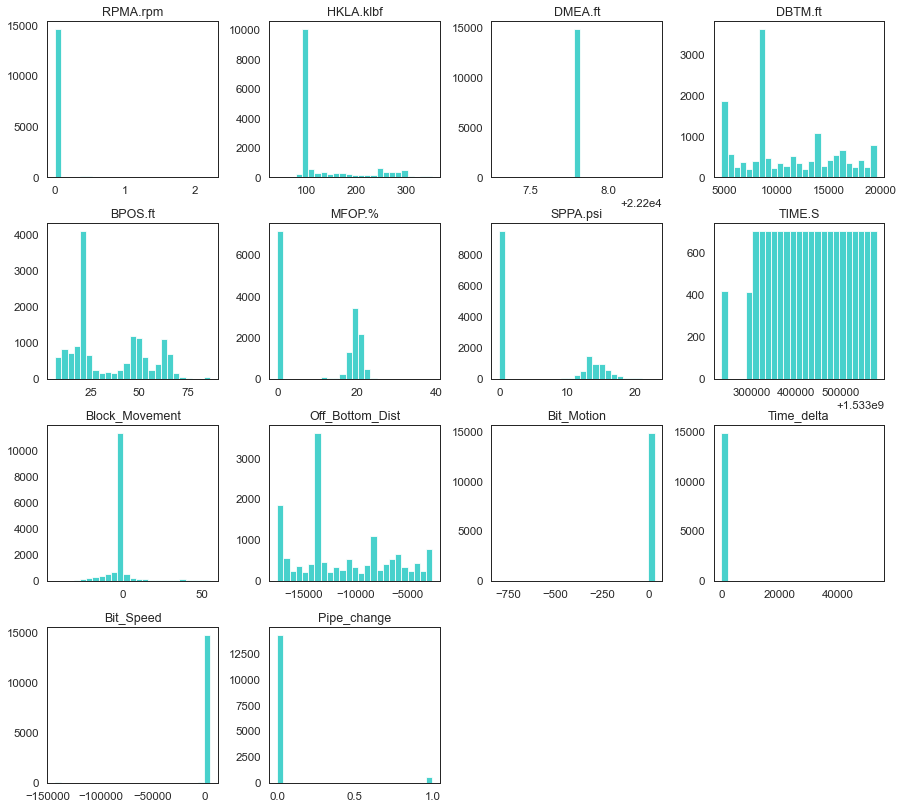

In [43]:
fig = plt.figure(figsize = (15,14))
sns.set(style="white", context = "paper", font_scale=1.3)

num_attributes.hist(bins = 25, ax = fig.gca(), grid = False, color = 'mediumturquoise');

plt.savefig('img/num_attributes1.png', dpi=1200, bbox_inches='tight')

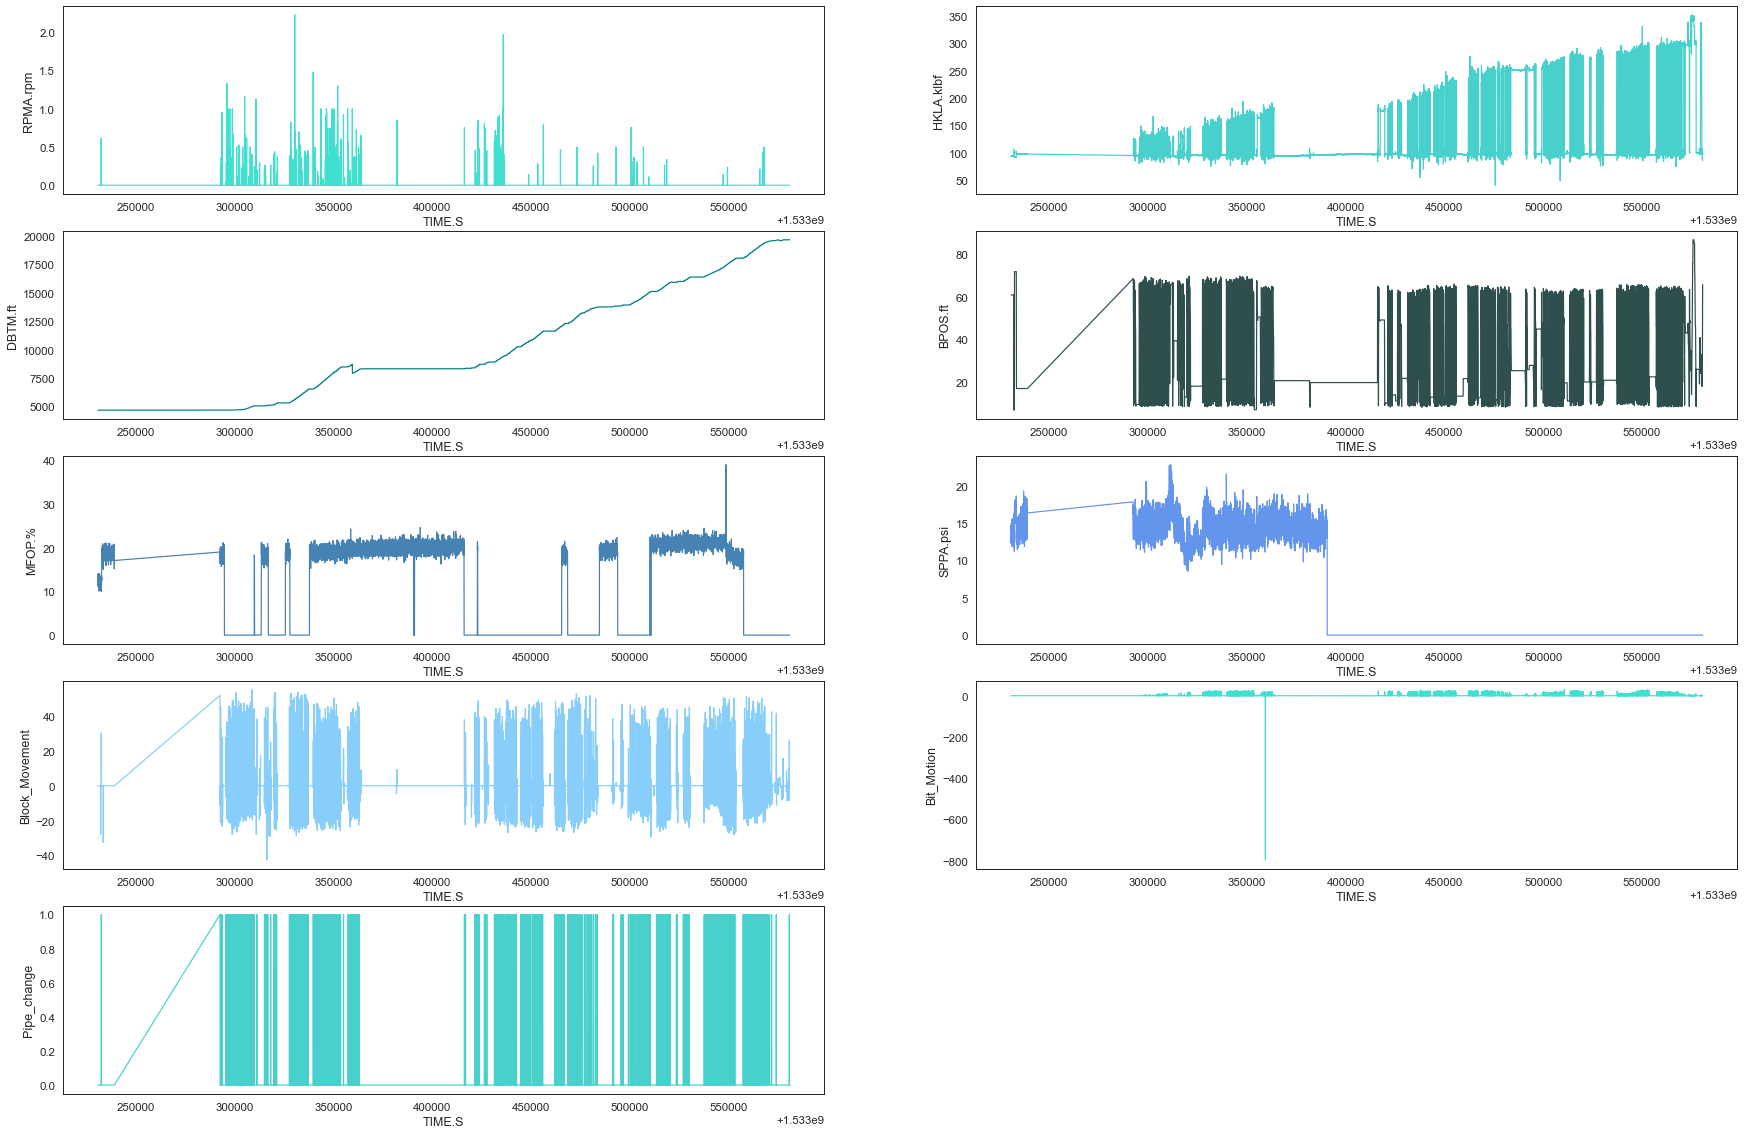

In [44]:
''' Here we will evaluate if there is any relationship between the features considered relevant. 
    Note that "Off_Botton_Dist" and "Bit_speed" have been disregarded as they are graphically 
    equivalent to ''DBTM.ft" and "Bit_motion". '''

aux1 = df4[['RPMA.rpm', 'HKLA.klbf', 'DBTM.ft', 'BPOS.ft', 'MFOP.%', 'SPPA.psi', 
            'Block_Movement','Bit_Motion', 'Pipe_change']]



sns.set(rc={'figure.figsize':(30,20)})
sns.set(style="white", context = "paper", font_scale=1.3)

plt.subplot (5,2,1)
sns_plot = sns.lineplot(x = 'TIME.S', y ='RPMA.rpm', data = df4, color = 'turquoise');

plt.subplot (5,2,2)
sns.lineplot(x = 'TIME.S', y ='HKLA.klbf', data = df4, color = 'mediumturquoise');

plt.subplot (5,2,3)
sns.lineplot(x = 'TIME.S', y ='DBTM.ft', data = df4, color = 'teal');

plt.subplot (5,2,4)
sns.lineplot(x = 'TIME.S', y ='BPOS.ft', data = df4, color = 'darkslategray');

plt.subplot (5,2,5)
sns.lineplot(x = 'TIME.S', y ='MFOP.%', data = df4, color = 'steelblue');

plt.subplot (5,2,6)
sns.lineplot(x = 'TIME.S', y ='SPPA.psi', data = df4, color = 'cornflowerblue');

plt.subplot (5,2,7)
sns.lineplot(x = 'TIME.S', y ='Block_Movement', data = df4, color = 'lightskyblue');

plt.subplot (5,2,8)
sns.lineplot(x = 'TIME.S', y ='Bit_Motion', data = df4, color = 'turquoise');

plt.subplot (5,2,9)
sns.lineplot(x = 'TIME.S', y ='Pipe_change', data = df4, color = 'mediumturquoise');

fig = sns_plot.get_figure()
fig.savefig("img/lineplot_num_attributes1.png")

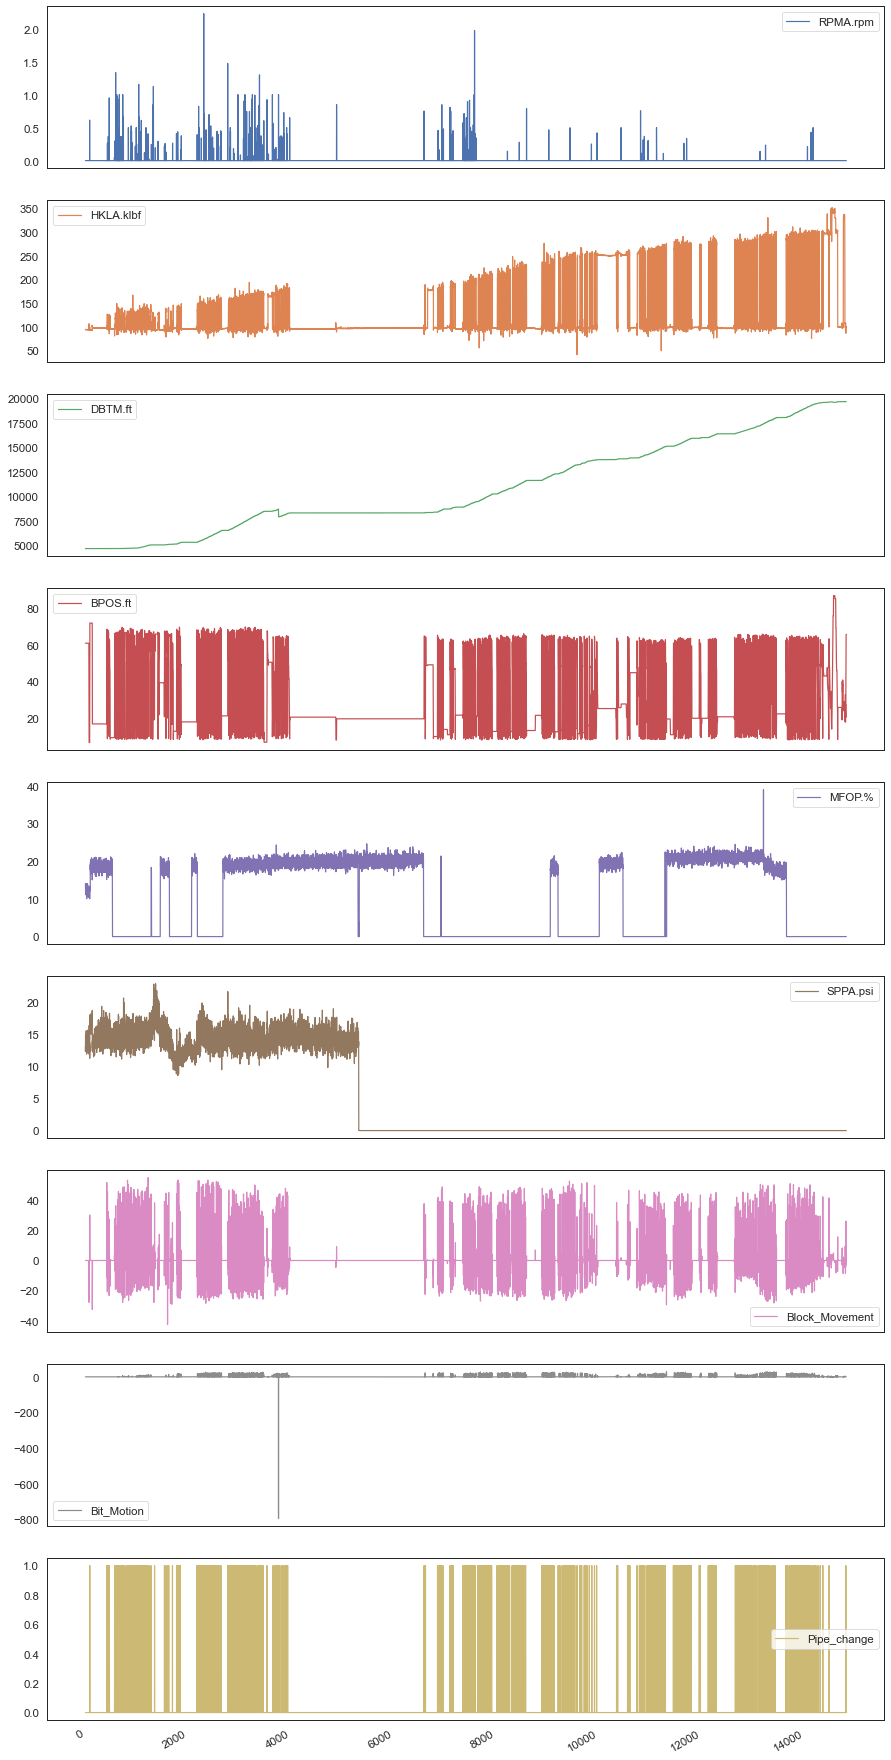

In [45]:
aux1 = df4[['RPMA.rpm', 'HKLA.klbf', 'DBTM.ft', 'BPOS.ft', 'MFOP.%', 'SPPA.psi', 
            'Block_Movement','Bit_Motion', 'Pipe_change']]

aux1.plot(subplots=True, figsize=(15,35))
plt.show()

We can note that there appears to have been a problem between the 4k and 7k data lines, as apparently almost no operational activity was taking place.

In [46]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,RPMA.rpm,0.00,2.23,2.23,0.01,0.00,0.07,14.14,259.67
1,HKLA.klbf,41.20,351.80,310.59,132.16,97.89,64.85,1.62,1.11
2,DMEA.ft,22207.80,22207.80,0.00,22207.80,22207.80,0.00,0.00,0.00
3,DBTM.ft,4675.50,19665.90,14990.40,10924.35,9017.00,4506.57,0.38,-1.06
4,BPOS.ft,6.60,86.90,80.30,34.20,25.20,18.94,0.43,-1.24
5,MFOP.%,0.00,39.00,39.00,10.19,17.00,9.91,-0.03,-1.95
6,SPPA.psi,0.00,22.82,22.82,5.12,0.00,6.91,0.66,-1.46
7,TIME.S,1533230800.00,1533580740.00,349940.00,1533430985.00,1533432480.00,88527.46,-0.14,-0.94
8,Block_Movement,-42.58,55.08,97.66,0.00,0.00,8.83,2.49,12.49
9,Off_Bottom_Dist,-17532.30,-2541.90,14990.40,-11283.45,-13190.80,4506.57,0.38,-1.06


In [47]:
aux1 = descriptive_statistics(num_attributes)
dfi.export(aux1, 'img/dataframe.png')

### 4.1.2 HOOKLOAD
If the hook load was calibrated with the top drive and hoses installed, its value should be close to zero due to the lack of load. However, the hook load is measured indirectly by a strain gauge in the dead line, and the weight of the top drive, elevator bails, elevator, top drive hoses, etc., is not taken into account during calibration. So, we need to analyze this data and define what will be the reference value for a Hookload during the slip connection.


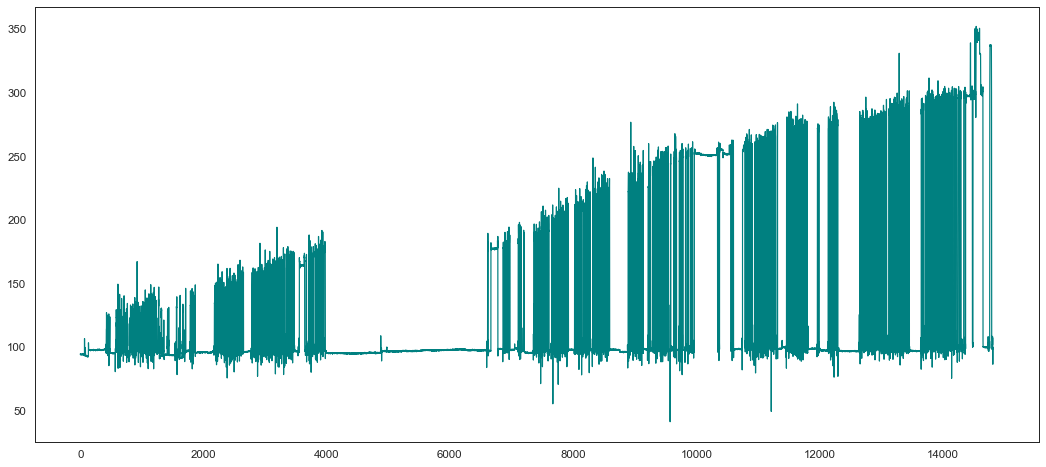

In [48]:
fig = plt.figure(figsize = (18,8))

df4['HKLA.klbf'].plot(color = 'teal')
plt.show()

fig.savefig("img/HKLA.klbf.png")

In the graph we can see that the average hookload value is gradually increasing. This is due to the fact that pipes are being attached to the system, thus increasing the total load to be carried. At the same time we can observe a practically linear average minimum value. This value represents the Hookload load when slips are connected to the pipe and Hookload is disconnected from the system. During this slip connection interval, we can observe a small elevation in Hookload, which represents the moment when it transports the new pipe to be connected to the system, where the pipe change occurs.

For the time been we will use **HKLA.klbf = 115 klbf** as a reference value for Hookload disconnected from the system.

### 4.1.3 ROTARY SPEED
We will expand the plot to analyze the outlier and decide whether to remove it or not.

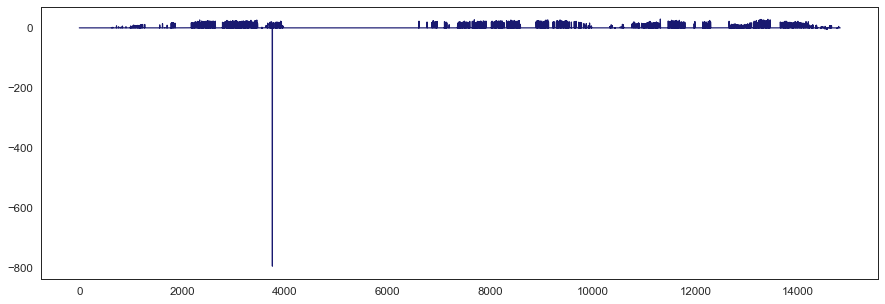

In [49]:
fig = plt.figure(figsize = (15,5))

df4['Bit_Motion'].plot(color = 'midnightblue')
plt.show()

fig.savefig("img/Bit_Motion1.png")

In [50]:
df4[df4['Bit_Motion']<-5]

,RPMA.rpm,HKLA.klbf,DMEA.ft,DBTM.ft,BPOS.ft,MFOP.%,SPPA.psi,TIME.S,Making_Hole,Block_Movement,Off_Bottom_Dist,Bit_Motion,DATETIME,Time_delta,Bit_Speed,Pipe_change
3762,1.00,93.23,22207.80,7920.30,12.24,19.77,13.30,1533359480,False,3.54,-14287.50,-796.30,08/04/2018 02:11:20,20.00,-143334.00,0


In [51]:
df4.drop(3762, axis = 0, inplace = True )
df4.reset_index(inplace = True)

In [52]:
df4.drop('index', axis = 1, inplace = True )

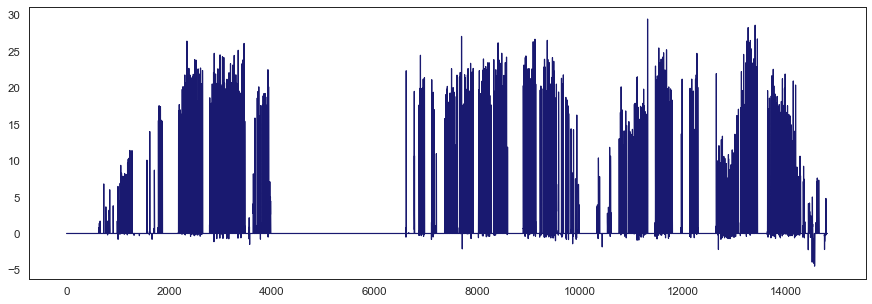

In [53]:
fig = plt.figure(figsize = (15,5))

df4['Bit_Motion'].plot(color = 'midnightblue')
plt.show()

fig.savefig("img/Bit_Motion2.png")

Bit Motion is a nice feature, as the bit movement is slightly less than zero when it is being prepared to initiate the slip connection.

### 4.1.4 Standpipe Pressure

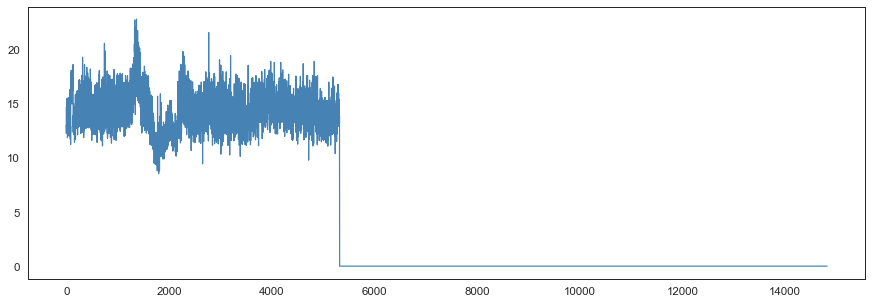

In [54]:
fig = plt.figure(figsize = (15,5))

df4['SPPA.psi'].plot(color = 'steelblue')
plt.show()

fig.savefig("img/SPPA.psi.png")

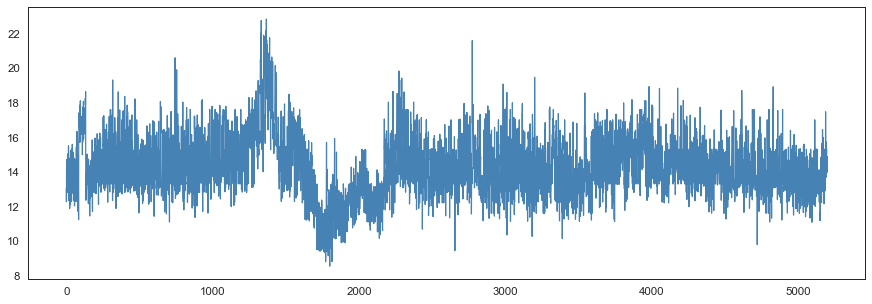

In [55]:
aux1 = df4.iloc[0:5200, :]
fig = plt.figure(figsize = (15,5))

aux1['SPPA.psi'].plot(color = 'steelblue')
plt.show()

fig.savefig("img/SPPA.psi2.png")

Standpipe pressure is a very important feature, however its data looks poorly measured and with a lot of noise, so at first we won't use it in our data analysis.

## 4.2 Bivariate Analysis

In [56]:
'''To plot the overlay graphics, we will use the Standard Normal Distribution (SND),
so that all values are rescaled between the range [0,1] or [-1,1] if there are negative values. 
For this we will use the estimator MinMaxScaler() from scikit-learn library.'''


mms = MinMaxScaler()

aux1 = df4.copy()
# numerical variable different from binary
aux1[['RPMA.rpm', 'HKLA.klbf', 'DBTM.ft', 'BPOS.ft', 'MFOP.%', 'Block_Movement', 
      'Bit_Motion', 'SPPA.psi']] = mms.fit_transform( aux1[['RPMA.rpm', 'HKLA.klbf', 'DBTM.ft', 'BPOS.ft', 
                                                            'MFOP.%', 'Block_Movement', 'Bit_Motion', 'SPPA.psi']])
aux1['TIME.s'] = df4['TIME.S']

### 4.2.1 Standpipe Pressure
We will analyze the performance of the feature compared to other features of importance for determining the slip connection and evaluate whether there is any relationship between them.

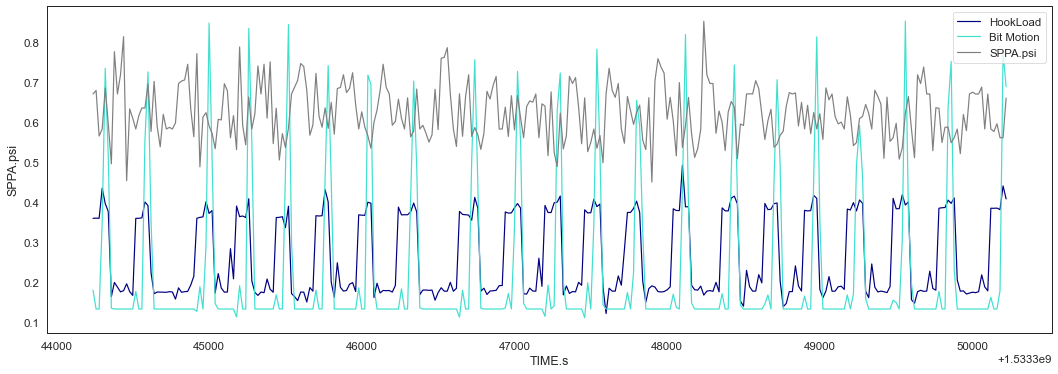

In [57]:
sns.set(rc={'figure.figsize':(18,6)})
sns.set(style="white", context = "paper", font_scale=1.3)

aux2 = aux1.iloc[3000:3300,:]

sns_plot = sns.lineplot(x = 'TIME.s', y ='HKLA.klbf', data = aux2, color = 'navy', label='HookLoad', alpha=1);
sns.lineplot(x = 'TIME.s', y ='Bit_Motion', data = aux2,color='turquoise', label='Bit Motion', alpha=1);
sns.lineplot(x = 'TIME.s', y ='SPPA.psi', data = aux2,color='gray', label='SPPA.psi', alpha=1);
plt.legend(loc='upper right');

fig = sns_plot.get_figure()
fig.savefig("img/lineplot1.png")

As previously predicted, the measurement data has too much noise to be considered.

### 4.2.2 Bit Motion
The feature created to determine the bit movement seems to be a good way out to replace the Standpipe pressure, since, as analyzed in the video and in articles, the bit does not move during the slip connection.
We can observe that the moment when bit motion is zero coincides with high hookload values, which are inversely related to the slip connection. In turn, during the slip connection, the hookload is low and the pipe change occurs.

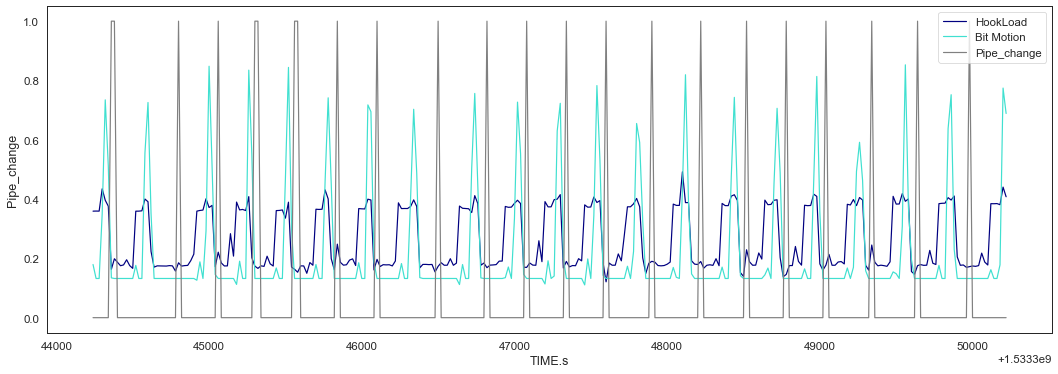

In [58]:
sns.set(rc={'figure.figsize':(18,6)})
sns.set(style="white", context = "paper", font_scale=1.3)

aux2 = aux1.iloc[3000:3300,:]

sns_plot = sns.lineplot(x = 'TIME.s', y ='HKLA.klbf', data = aux2, color = 'navy', label='HookLoad', alpha=1);
sns.lineplot(x = 'TIME.s', y ='Bit_Motion', data = aux2,color='turquoise', label='Bit Motion', alpha=1);
sns.lineplot(x = 'TIME.s', y ='Pipe_change', data = aux2,color='gray', label='Pipe_change', alpha=1);
plt.legend(loc='upper right');

fig = sns_plot.get_figure()
fig.savefig("img/lineplot2.png")

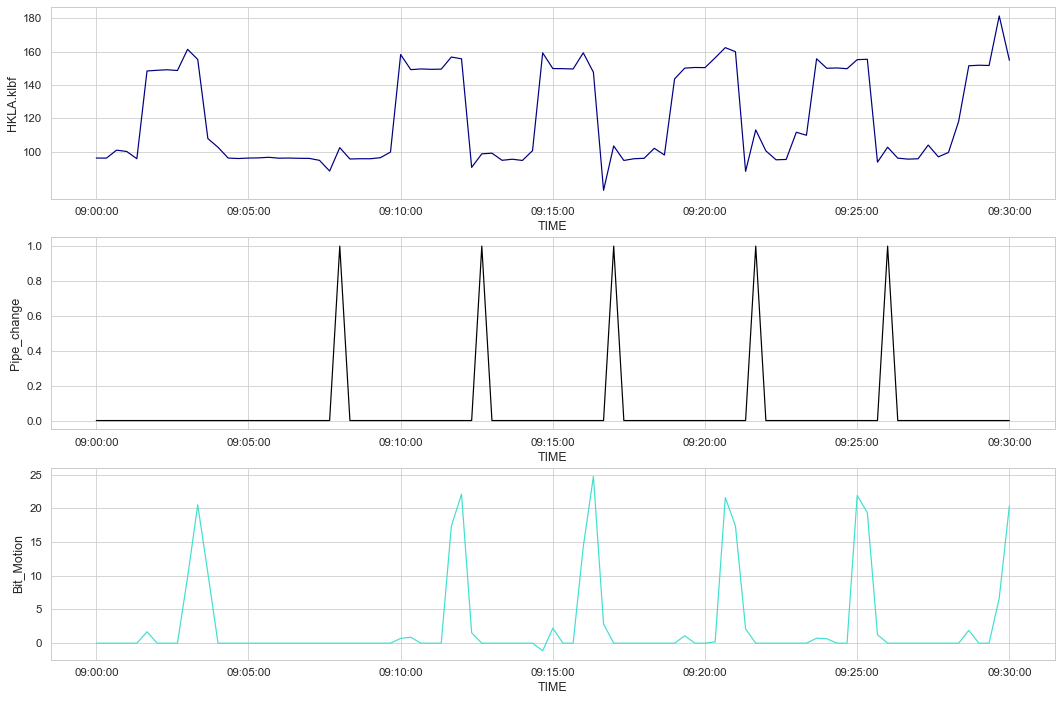

In [59]:
aux2 = df4[(1533342600 >= df4['TIME.S']) & (df4['TIME.S'] >= 1533340800)]

aux2['DATETIME'] = pd.to_datetime(aux2['DATETIME'])

aux2.reset_index(inplace = True)

for i in range(len(aux2)):
    aux2.loc[i, 'TIME'] = datetime.strftime(aux2.loc[i, 'DATETIME'], "%H:%M:%S")

sns.set(rc={'figure.figsize':(18,12)})
sns.set(style="whitegrid", context = "paper", font_scale=1.3)

plt.subplot (3,1,1)
sns_plot = ax = sns.lineplot(x = 'TIME', y ='HKLA.klbf', data = aux2, color = 'navy');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);
ax.set_yticks([100,120,140,160,180])
#plt.xticks(rotation = 45);

plt.subplot (3,1,3)
ax = sns.lineplot(x = 'TIME', y ='Bit_Motion', data = aux2, color = 'turquoise');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);
#plt.xticks(rotation = 90);

plt.subplot (3,1,2)
ax = sns.lineplot(x = 'TIME', y ='Pipe_change', data = aux2, color = 'black');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);
#plt.xticks(rotation = 90);

fig = sns_plot.get_figure()
fig.savefig("img/lineplot3.png")

With this graphs we can analyze a great relationship between the features and establish a way to estimate the slip connection.

## 4.3 Multivariate Analysis


In [60]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
num_attributes.drop(['Pipe_change'], axis = 1, inplace = True )
bin_attributes = df4[['Pipe_change']]

### 4.3.1 Numerical Attributes


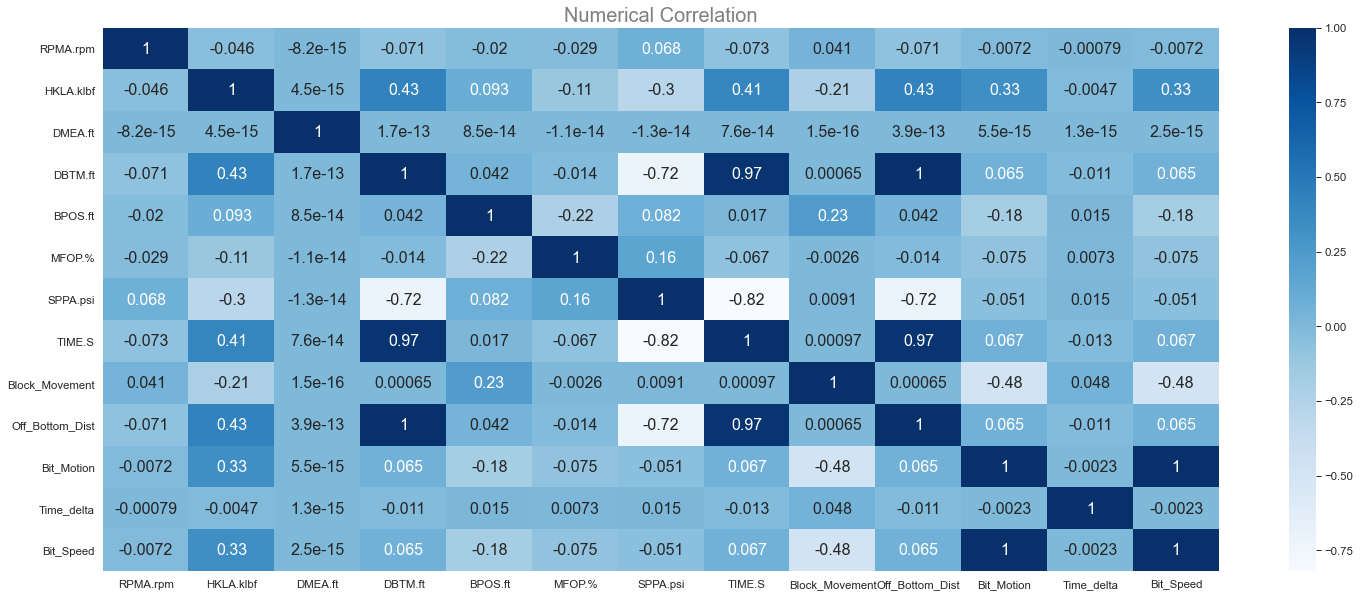

In [61]:
fig = plt.figure(figsize = (25,10))
correlation = num_attributes.corr(method = 'pearson')
sns_plot = sns.heatmap(correlation, annot = True, annot_kws={"fontsize":16}, cmap="Blues");
plt.title("Numerical Correlation", size=20, color='gray');

fig = sns_plot.get_figure()
fig.savefig("img/heatmap.png")

### 4.3.2 Binary x Numerical Attributes

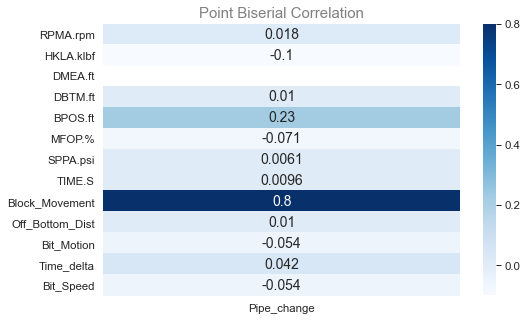

In [62]:
## Only numerical and binary data

# Calculate point bisserial correlation
x1 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['RPMA.rpm'])[0]
x2 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['HKLA.klbf'])[0]
x3 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['DMEA.ft'])[0]
x4 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['DBTM.ft'])[0]
x5 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['BPOS.ft'])[0]
x6 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['MFOP.%'])[0]
x7 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['SPPA.psi'])[0]
x8 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['TIME.S'])[0]
x9 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['Block_Movement'])[0]
x10 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['Off_Bottom_Dist'])[0]
x11 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['Bit_Motion'])[0]
x12 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['Time_delta'])[0]
x13 = pointbiserialr(bin_attributes['Pipe_change'], num_attributes['Bit_Speed'])[0]

# Final dataset
d = pd.DataFrame({'Pipe_change':[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]})

# Sets the index equal to columns
d = d.set_index(num_attributes.columns)

fig = plt.figure(figsize = (8,5))
sns_plot = sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Point Biserial Correlation", size=15,color='gray');

fig = sns_plot.get_figure()
fig.savefig("img/heatmap2.png")

## 4.4 Features Relevance Resume

In [63]:
# display columns complete description
pd.set_option('display.max_colwidth', None)

# Hypothesis Summary dataframe
summary = pd.DataFrame({'Feature':['RPMA.rpm','HKLA.klbf', 'DMEA.ft', 'DBTM.ft', 'BPOS.ft', 'MFOP.%',
                                   'SPPA.psi', 'TIME.S', 'Making_Hole', 'Block_Movement','Off_Bottom_Dist', 
                                   'Bit_Motion', 'DATETIME', 'Time_delta', 'Bit_Speed', 'Pipe_change'],
                                      
                        'Feature Description':['Rotary Speed (surface, average)', 'Hookload (average)', 
                                       'Depth hole (measured)', 'Depth bit (measured)', 'Block position (in ft)', 
                                       'Mud flow out (percentual )', 'Standpipe pressure (average)', 'Time in seconds', 
                                       'Hole beem made or not','Block movement (diff of block position)', 
                                       'Distance from depth bit and hole','Difference of bit position', 
                                       'Date and time', 'Difference of time', 'bit motion / time passed', 
                                       'Pipe been changed or not'], 
                        
                        'Relevance (Low/ Medium/ High)':['Medium', 'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'Low', 'Medium',
                                     'Low','High','Low', 'Low', 'High', 'High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


dfi.export(summary, 'img/relevance.png')

summary

,Feature,Feature Description,Relevance (Low/ Medium/ High)
1,RPMA.rpm,"Rotary Speed (surface, average)",Medium
2,HKLA.klbf,Hookload (average),High
3,DMEA.ft,Depth hole (measured),Low
4,DBTM.ft,Depth bit (measured),Low
5,BPOS.ft,Block position (in ft),Low
6,MFOP.%,Mud flow out (percentual ),Low
7,SPPA.psi,Standpipe pressure (average),Low
8,TIME.S,Time in seconds,High
9,Making_Hole,Hole beem made or not,Low
10,Block_Movement,Block movement (diff of block position),Medium


# 5.0 RESPONSE VARIABLE

As the time variation is constant, the bit position and bit motion have the same relevance and influence on our response variable, so we can only use one of them.

Therefore, to evaluate the performance of the response variable obtained, we will consider:

- bit motion
- hookload
- change pipe
- Time

## 5.1 First try

In order not to overfit the response variable, we will start with the condition:

- pipe change = 1, and we'll look at the 4 minutes of data before and after.
- If the Hookload of these data is less than or equal to 150klbf, we will consider it as a slip connection.

In [64]:
i = 0

while i < (len(df4) ):
    
    if (df4.loc[i,'Pipe_change'] == 1):
        a = (i - 12)
        while a < (i + 12):
            
            if (df4.loc[a,'HKLA.klbf'] <= 150):

                df4.at[a, 'Slip_conn'] = 1
                
            else:
                df4.at[a, 'Slip_conn'] = 0
                
            a = a + 1
        i = i + 12
    else:
        df4.at[i , 'Slip_conn'] = 0
        i = i + 1

KeyError: 14824

In [65]:
df4['Slip_conn'].value_counts()

0.00    9611
1.00    5213
Name: Slip_conn, dtype: int64

### 5.1.1 Result Analysis

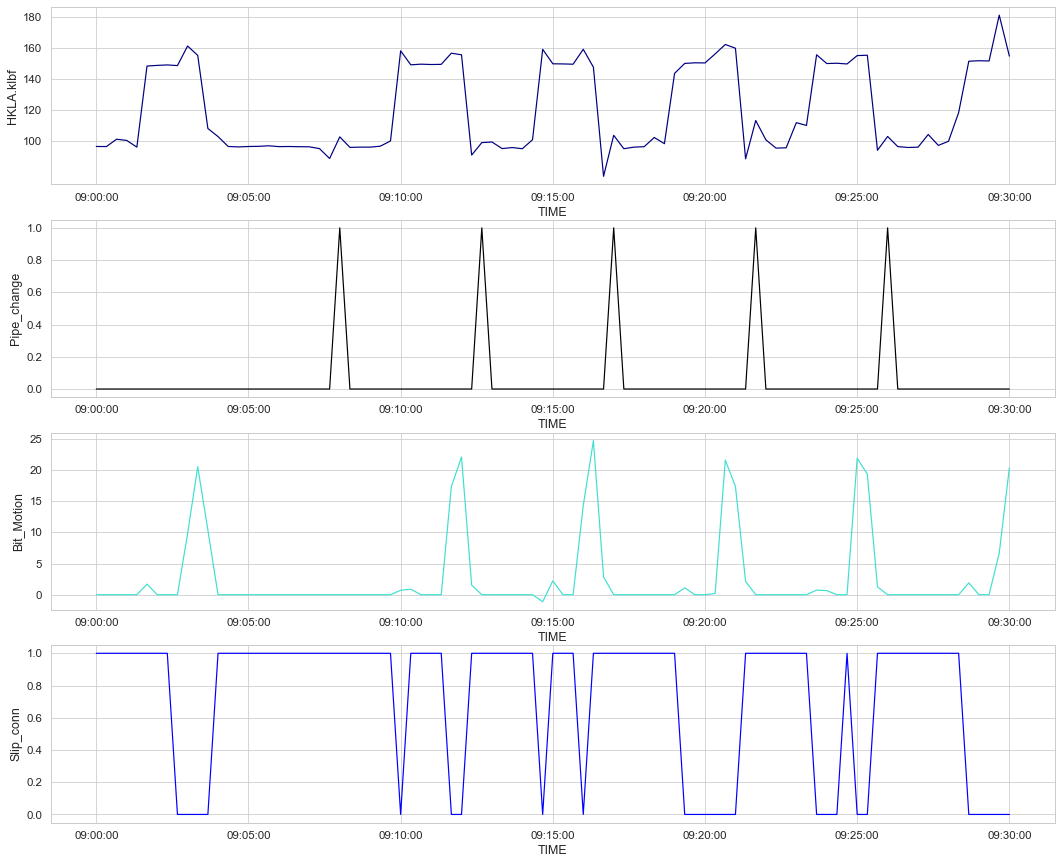

In [66]:
aux2 = df4[(1533342600 >= df4['TIME.S']) & (df4['TIME.S'] >= 1533340800)]

aux2['DATETIME'] = pd.to_datetime(aux2['DATETIME'])

aux2.reset_index(inplace = True)

for i in range(len(aux2)):
    aux2.loc[i, 'TIME'] = datetime.strftime(aux2.loc[i, 'DATETIME'], "%H:%M:%S")

sns.set(rc={'figure.figsize':(18,15)})
sns.set(style="whitegrid", context = "paper", font_scale=1.3)

plt.subplot (4,1,1)
ax = sns.lineplot(x = 'TIME', y ='HKLA.klbf', data = aux2, color = 'navy');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);
ax.set_yticks([100,120,140,160,180])

plt.subplot (4,1,3)
ax = sns.lineplot(x = 'TIME', y ='Bit_Motion', data = aux2, color = 'turquoise');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

plt.subplot (4,1,2)
ax = sns.lineplot(x = 'TIME', y ='Pipe_change', data = aux2, color = 'black');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

plt.subplot (4,1,4)
ax = sns.lineplot(x = 'TIME', y ='Slip_conn', data = aux2, color = 'blue');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

## 5.2 Sencond try

We can observe that the inclusion of the bit motion is necessary, since the data is wrongly suggesting a 'slip connection' status during the movement that the bit performs right after the slip is disconnect.

In [67]:
# classify the operation based on the variable values

i = 0

while i < (len(df4) ):
    
    if (df4.loc[i,'Pipe_change'] == 1):
        a = (i - 12)
        while a < (i + 12):
            
            if (df4.loc[a,'HKLA.klbf'] <= 150) and (df4.loc[a,'Bit_Motion'] == 0):

                df4.at[a, 'Slip_conn'] = 1
                
            else:
                df4.at[a, 'Slip_conn'] = 0
                
            a = a + 1
        i = i + 12
    else:
        df4.at[i , 'Slip_conn'] = 0
        i = i + 1

KeyError: 14824

In [ ]:
df4['Slip_conn'].value_counts()

### 5.2.1 Result Analysis

In [ ]:
aux2 = df4[(1533342600 >= df4['TIME.S']) & (df4['TIME.S'] >= 1533340800)]

aux2['DATETIME'] = pd.to_datetime(aux2['DATETIME'])

aux2.reset_index(inplace = True)

for i in range(len(aux2)):
    aux2.loc[i, 'TIME'] = datetime.strftime(aux2.loc[i, 'DATETIME'], "%H:%M:%S")

sns.set(rc={'figure.figsize':(18,15)})
sns.set(style="whitegrid", context = "paper", font_scale=1.3)

plt.subplot (4,1,1)
ax = sns.lineplot(x = 'TIME', y ='HKLA.klbf', data = aux2, color = 'navy');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);
ax.set_yticks([100,120,140,160,180])

plt.subplot (4,1,3)
ax = sns.lineplot(x = 'TIME', y ='Bit_Motion', data = aux2, color = 'turquoise');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

plt.subplot (4,1,2)
ax = sns.lineplot(x = 'TIME', y ='Pipe_change', data = aux2, color = 'black');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

plt.subplot (4,1,4)
ax = sns.lineplot(x = 'TIME', y ='Slip_conn', data = aux2, color = 'blue');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

## 5.3 Final response variable

We can observe that, over time, as the drilling takes place, the hookload increases, as does the load of the pipes it supports when performing the connection during the slip connection. With that in mind, we chose the value of 150klbf as a reference. As the difference in Hookload from the beginning to the end of the dataframe is very big, our condition is covering data from the moment after the slip disconnection, in which, after the new pipe is connected and the bit makes a slight movement, the bit stops for some moments to resume your downward movement.

Therefore, we conclude that the Hookload reference value at the end of the data cannot be the same as at the beginning, so that this problem does not occur. Therefore, we will consider 130 for the first 6000 rows and 150 for the rest.

Regarding bit motion, we will consider a small deviation [1,-1] to minimize the noise effects.

In [ ]:
fig = plt.figure(figsize = (18,5))

df4['HKLA.klbf'].plot(color = 'teal')
plt.show()

In [68]:
# classify the operation based on the variable values
i = 0

while i < (len(df4) + 1):
    
    if (df4.loc[i,'Pipe_change'] == 1):
        a = (i - 12)
        while a < (i + 12):
            if (i < 6000):
                if (df4.loc[a,'HKLA.klbf']<= 130) and (df4.loc[a,'Bit_Motion']<= 1) and (df4.loc[a,'Bit_Motion']>= -1):

                    df4.at[a, 'Slip_conn'] = 1
                
                else:
                    df4.at[a, 'Slip_conn'] = 0
            else:    
                if (df4.loc[a,'HKLA.klbf']<= 150) and (df4.loc[a,'Bit_Motion']<= 1) and (df4.loc[a,'Bit_Motion']>= -1):

                    df4.at[a, 'Slip_conn'] = 1

                else:
                    df4.at[a, 'Slip_conn'] = 0

            a = a + 1
        i = i + 12
    else:
        df4.at[i , 'Slip_conn'] = 0
        i = i + 1

KeyError: 14824

In [ ]:
df4['Slip_conn'].value_counts()

### 5.3.1 Result Analysis

In [ ]:
aux2 = df4[(1533342600 >= df4['TIME.S']) & (df4['TIME.S'] >= 1533340800)]

aux2['DATETIME'] = pd.to_datetime(aux2['DATETIME'])

aux2.reset_index(inplace = True)

for i in range(len(aux2)):
    aux2.loc[i, 'TIME'] = datetime.strftime(aux2.loc[i, 'DATETIME'], "%H:%M:%S")

sns.set(rc={'figure.figsize':(18,15)})
sns.set(style="whitegrid", context = "paper", font_scale=1.3)

plt.subplot (4,1,1)
sns_plot = ax = sns.lineplot(x = 'TIME', y ='HKLA.klbf', data = aux2, color = 'navy');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);
ax.set_yticks([100,120,140,160,180])
plt.title('Initial piece of data when the maximum Hookload is approximately 160klbf.');

plt.subplot (4,1,3)
ax = sns.lineplot(x = 'TIME', y ='Bit_Motion', data = aux2, color = 'turquoise');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

plt.subplot (4,1,2)
ax = sns.lineplot(x = 'TIME', y ='Pipe_change', data = aux2, color = 'black');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

plt.subplot (4,1,4)
ax = sns.lineplot(x = 'TIME', y ='Slip_conn', data = aux2, color = 'blue');
ax.set_xticks(['09:00:00','09:05:00','09:10:00', '09:15:00', '09:20:00', '09:25:00', '09:30:00']);

fig = sns_plot.get_figure()
fig.savefig("img/lineplot_slip_conn.png")

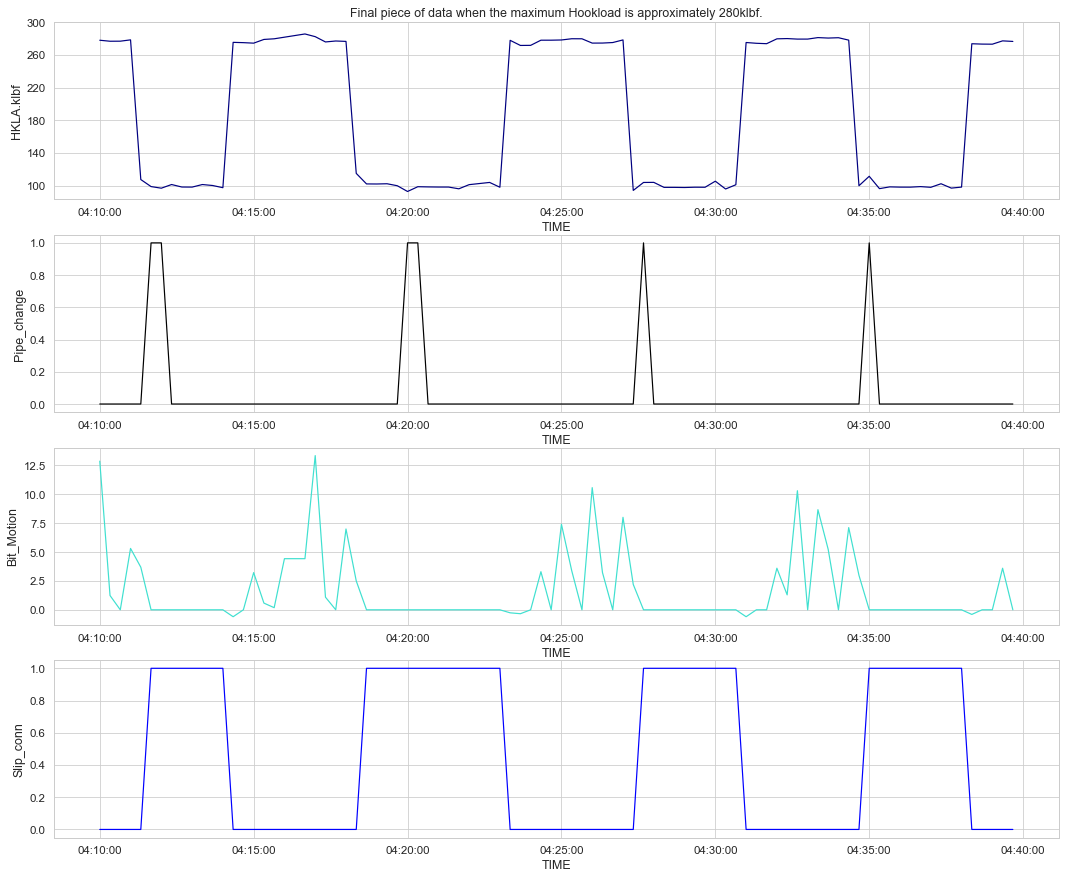

In [69]:
aux2 = df4[(1533541195 >= df4['TIME.S']) & (df4['TIME.S'] >= 1533539395)]

aux2['DATETIME'] = pd.to_datetime(aux2['DATETIME'])

aux2.reset_index(inplace = True)

for i in range(len(aux2)):
    aux2.loc[i, 'TIME'] = datetime.strftime(aux2.loc[i, 'DATETIME'], "%H:%M:%S")

sns.set(rc={'figure.figsize':(18,15)})
sns.set(style="whitegrid", context = "paper", font_scale=1.3)

plt.subplot (4,1,1)
sns_plot = ax = sns.lineplot(x = 'TIME', y ='HKLA.klbf', data = aux2, color = 'navy');
ax.set_xticks(['04:10:00','04:15:00','04:20:00', '04:25:00', '04:30:00', '04:35:00', '04:40:00']);
ax.set_yticks([100,140,180,220,260, 300])
plt.title('Final piece of data when the maximum Hookload is approximately 280klbf.');

plt.subplot (4,1,3)
ax = sns.lineplot(x = 'TIME', y ='Bit_Motion', data = aux2, color = 'turquoise');
ax.set_xticks(['04:10:00','04:15:00','04:20:00', '04:25:00', '04:30:00', '04:35:00', '04:40:00']);

plt.subplot (4,1,2)
ax = sns.lineplot(x = 'TIME', y ='Pipe_change', data = aux2, color = 'black');
ax.set_xticks(['04:10:00','04:15:00','04:20:00', '04:25:00', '04:30:00', '04:35:00', '04:40:00']);

plt.subplot (4,1,4)
ax = sns.lineplot(x = 'TIME', y ='Slip_conn', data = aux2, color = 'blue');
ax.set_xticks(['04:10:00','04:15:00','04:20:00', '04:25:00', '04:30:00', '04:35:00', '04:40:00']);

fig = sns_plot.get_figure()
fig.savefig("img/lineplot_slip_conn_final.png")

## 6.0 BUSINESS PERFORMANCE

In [70]:
df5 = df4.copy()

In [71]:
df5['Slip_conn'].sum()

4588.0

In [72]:
df5['Pipe_change'].sum()

542

In [73]:
#mean time:
mean_time = (((df5['Slip_conn'].sum())/(df5['Pipe_change'].sum()))*20) / 60
mean_lost_time = mean_time - 1.5
lost_time = (df5['Slip_conn'].sum() - (df5['Pipe_change'].sum()*6))/60

In [74]:
aux1 = pd.DataFrame({'Mean slip time measured(min)':mean_time, 
                     'Ideal slip time measured(min)':1.5, 
                     'Mean Lost time per slip (min)':mean_lost_time,
                     'Total Lost time (hours)': lost_time}, index =[0])
aux1

,Mean slip time measured(min),Ideal slip time measured(min),Mean Lost time per slip (min),Total Lost time (hours)
0,2.82,1.50,1.32,22.27


In [78]:
df5.to_excel("final_data1.xlsx") 

In [80]:
df5.shape

(14824, 17)